<a href="https://colab.research.google.com/github/taylan-sen/CIS490/blob/main/custom_simple_planar_robot_pybullet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build your own robot in PyBullet

This tutorial shows you how to build a really simple robot that can move only in a plane!

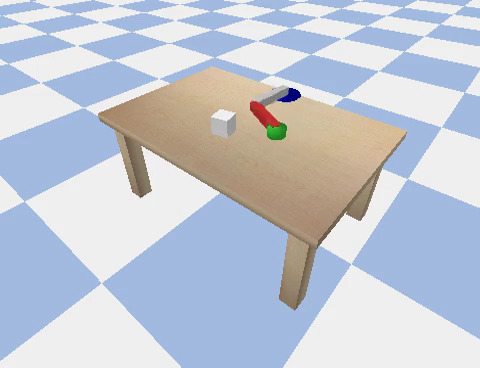

In [ ]:
!pip install pybullet==3.1.6 imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

     |████████████████████████████████| 79.0 MB 69 kB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 


In [2]:
# Write custom robot URDF. See http://wiki.ros.org/urdf/Tutorials

urdf_str = '''
<?xml version="1.0"?>
<robot name="myrobot">
  <link name="base_link">
    <visual>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
      <material name="blue">
        <color rgba="0 0 .8 1"/>
      </material>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="arm">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="white">
        <color rgba="0.8 0.8 .8 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="base_to_arm" type="revolute">
    <parent link="base_link"/>
    <child link="arm"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0 0"/>
    <limit effort="1000.0" lower="0.0" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="arm2">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="red">
        <color rgba="0.8 0.2 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm_to_arm2" type="revolute">
    <parent link="arm"/>
    <child link="arm2"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="end_effector">
    <visual>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <material name="greeb">
        <color rgba="0.2 0.8 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm2_to_end_effector" type="revolute">
    <parent link="arm2"/>
    <child link="end_effector"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

</robot>
'''

with open('custom_robot.urdf', 'w') as f:
    f.write(urdf_str)

In [ ]:
p.connect(p.DIRECT) # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

plane_id = p.loadURDF("plane.urdf")
robot_id = p.loadURDF("custom_robot.urdf", basePosition=[1.400000, -0.200000, 0.650000], useFixedBase=True)
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
cube_id = p.loadURDF("cube.urdf", basePosition=[0.9, -0.2, 0.675], globalScaling=0.1)

num_joints = p.getNumJoints(robot_id)
print('Num of joints in robot:', num_joints)

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

for t in range(5000):
    print(f'\rtimestep {t}...', end='')

    if t % 8 == 0: # PyBullet default simulation time step is 240fps, but we want to record video at 30fps.
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        vid.send(np.ascontiguousarray(image))
    
    target_pos = [1.1, -0.2 + 0.5*math.cos(2*math.pi*t/1200), 0.65]
    if t > 3000: target_pos[0] = 0.95
    target_orn = p.getQuaternionFromEuler([math.pi, 0, 0])
    joint_poses = p.calculateInverseKinematics(robot_id, 2, target_pos, target_orn)
    for j in range(num_joints):
        p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j])
    '''
    joint_angle = 3*math.sin(2*math.pi*t/600)
    p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=1, controlMode=p.POSITION_CONTROL, targetPosition=joint_angle)
    '''

    p.stepSimulation()

plt.imshow(Image.fromarray(image)) # show the last frame

vid.close()
p.disconnect()

In [ ]:
# Play recorded video

mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)